<a href="https://colab.research.google.com/github/SLVmain/PyTorch_start/blob/Les_02/GB_HW_02_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feed-forward сети

Итак, давайте потренируемся тренировать нейронные сети прямого распространения (так как делали на паре)
При этом попробуем создать свою функцию активации на одном из слоев

In [11]:
# Сделаем необходимые импорты
import torch
import numpy as np

from torch import nn
import torchvision

from torch import optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
from PIL import Image

In [3]:
# Загрузим датасет CIFAR-100, сразу же создадим dataloader для него
# Если вам не хватает вычислительных ресурсов, то можно вернуться к CIFAR-10

train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)


image, label = train_dataset[0]
print (image.size())
print (label)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
torch.Size([3, 32, 32])
6


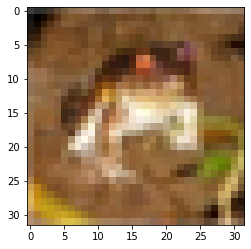

In [9]:
plt.imshow(image.permute(1, 2, 0).numpy())

In [10]:
image, label = train_dataset[9]
print(image.size())
print(image[1].size())
print(type(image)) 
print(label)

torch.Size([3, 32, 32])
torch.Size([32, 32])
<class 'torch.Tensor'>
3


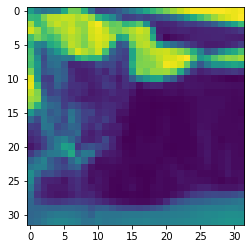

In [14]:
im = image.numpy()[1]
x = Image.fromarray((im * 255).astype(np.uint8))
plt.imshow(x)   #(x.convert('RGBA'))
plt.show()

In [15]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [16]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False)

Files already downloaded and verified


In [17]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [18]:
3 * 32 * 32

3072

In [44]:
# ВОПРОС: можно ли написать без наследования от Module?

class MyLeakyRelu(nn.Module):
    def __init__(self, border, alpha):
        super().__init__()
        self.alpha = alpha
        self.border = border
        
    def forward(self, input):
        x = F.leaky_relu(input)
        return torch.where(x > self.border, x * self.alpha, x)

In [45]:
# Создайте собственную архитектуру! Можете использовать все, что угодно, но в ограничении на использование линейные слои (пока без сверток)
# Давайте добавим ограниченный Leaky_relu, то есть output = max(0.1x, 0.5x)
# Ваша задача добавить его в архитектуру сети как функцию активации

import torch.nn.functional as F


class Classification(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.my_relu = MyLeakyRelu(0.1, 0.5)
        self.layer1 = nn.Linear(input_dim, 4 * hidden_dim)
        self.batch1 = nn.BatchNorm1d(4 * hidden_dim)
        self.layer2 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.batch2 = nn.BatchNorm1d(2 * hidden_dim)
        self.layer3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.layer4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.layer1(x)
        x = self.my_relu(x) # здесь пишем самописную активацию
        x = self.batch1(x)
        x = self.layer2(x)
        x = F.leaky_relu(x, 0.05)
        x = self.batch2(x)
        x = self.layer3(x)
        x = F.leaky_relu(x, 0.05)
        x = self.layer4(x)
        x = F.softmax(x)
        return x


net = Classification(3072, 100, 10)

In [ ]:
# Запустить обучение (по аналогии с тем, что делали на паре)

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [47]:
from tqdm import tqdm

In [48]:
for epoch in tqdm(range(10)):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Training is finished!')

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,     1] loss: 0.001
[1,   301] loss: 0.342
[1,   601] loss: 0.334


 10%|█         | 1/10 [00:16<02:32, 16.93s/it]

[2,     1] loss: 0.001
[2,   301] loss: 0.325
[2,   601] loss: 0.321


 20%|██        | 2/10 [00:37<02:32, 19.07s/it]

[3,     1] loss: 0.001
[3,   301] loss: 0.316
[3,   601] loss: 0.315


 30%|███       | 3/10 [00:54<02:05, 17.98s/it]

[4,     1] loss: 0.001
[4,   301] loss: 0.313
[4,   601] loss: 0.311


 40%|████      | 4/10 [01:11<01:45, 17.63s/it]

[5,     1] loss: 0.001
[5,   301] loss: 0.309
[5,   601] loss: 0.309


 50%|█████     | 5/10 [01:28<01:26, 17.36s/it]

[6,     1] loss: 0.001
[6,   301] loss: 0.307
[6,   601] loss: 0.307


 60%|██████    | 6/10 [01:44<01:08, 17.08s/it]

[7,     1] loss: 0.001
[7,   301] loss: 0.305
[7,   601] loss: 0.305


 70%|███████   | 7/10 [02:01<00:50, 16.89s/it]

[8,     1] loss: 0.001
[8,   301] loss: 0.303
[8,   601] loss: 0.304


 80%|████████  | 8/10 [02:17<00:33, 16.72s/it]

[9,     1] loss: 0.001
[9,   301] loss: 0.302
[9,   601] loss: 0.304


 90%|█████████ | 9/10 [02:33<00:16, 16.62s/it]

[10,     1] loss: 0.001
[10,   301] loss: 0.301
[10,   601] loss: 0.301


100%|██████████| 10/10 [02:50<00:00, 17.03s/it]

Training is finished!
